# Demos for analyzing World Color Survey (WCS)

COG 260: Data, Computation, and The Mind (Yang Xu)

Data source: http://www1.icsi.berkeley.edu/wcs/data.html

______________________________________________

Import helper function file for WCS data analysis.

In [1]:
from wcs_helper_functions import *

Import relevant Python libraries.

In [2]:
import numpy as np
from scipy import stats
from scipy import spatial  
from random import random
from string import ascii_lowercase
from sklearn.model_selection import LeaveOneOut
%matplotlib inline

## Demo 1: Import stimulus (color chip) information in [Munsell space](https://en.wikipedia.org/wiki/Munsell_color_system)

> Stimuli were 330 color chips in Munsell space, each defined along lightness and hue dimensions.

> Each color chip has an index _(from 1 to 330)_ and a coordinate (lightness *(alphabet)*, hue *(integer)*).

In the following section, you will learn how to convert from **(a) index to coordinate** and **(b) coordinate to index**.

______________________________________________

Load chip information in Munsell space. 

`munsellInfo` is a 2-element tuple with dictionary elements.

In [3]:
munsellInfo = readChipData('./WCS_data_core/chip.txt');

### (a) Index &rarr; Coordinate

Access the second dictionary in `munsellInfo`.

In [4]:
indexCoord = munsellInfo[1]

`indexCoord` is a dictionary with **index _(key)_ &rarr; coordinate _(value)_** pairs. For example, to retrieve the Munsell coordinate _(lightness, hue)_ for chip with numerical index 1:

In [5]:
print(indexCoord[1])

('E', '29')


You can also uncomment the following to display full stimulus information (long).

In [6]:
# print(indexCoord)

### (b) Coordinate &rarr; Index

Access the first dictionary in `munsellInfo`.

In [7]:
coordIndex = munsellInfo[0]

`coordIndex` is a dictionary with **coordinate _(key)_ &rarr; index _(value)_** pairs. For example, to access numerical index for the color chip at Munsell coordinate _(D, 11)_:

In [8]:
print(coordIndex['D11'])

258


You can also uncomment the following to display full stimulus information (long).

In [9]:
# print(coordIndex)

## Demo 2: Import stimulus information in [CIELAB space](https://en.wikipedia.org/wiki/Lab_color_space)

> Each of the 330 stimuli can also be mapped to the 3D CIELAB space, where the dimensions are `l` _(lightness)_, `a`, & `b` _(color opponency)_.

> CIELAB Coordinates have a **one-to-one** correspondence with Munsell index, which ranges from 1 to 330.

______________________________________________

Load chip coordinates in CIELAB. 

`cielabCoord` is a dictionary with **index _(key)_ &rarr; CIELAB Coordinate _(value)_** pairs.

In [10]:
cielabCoord = readClabData('./WCS_data_core/cnum-vhcm-lab-new.txt')

For example, to obtain the CIELAB coordinates for chip with numerical index 1:

In [11]:
print(cielabCoord[1])

('61.70', '-4.52', '-39.18')


## Demo 3: Import color naming data
    
> Each of the 330 color chips was named by speakers of 110 different languages.

______________________________________________

Load naming data. 

`namingData` is a hierarchical dictionary organized as follows:

**language _(1 - 110)_ &rarr; speaker _(1 - *range varies per language*)_ &rarr; chip index _(1 - 330)_ &rarr; color term**

In [12]:
namingData = readNamingData('./WCS_data_core/term.txt')

For example, to obtain naming data from language 1 and speaker 1 for all 330 color chips:

In [13]:
namingData[1][1]; # remove semicolon to see data in full

For example, to see how many speakers language 1 has:

In [14]:
len(namingData[1])

25

## Demo 4: Import color foci data
    
> Apart from naming the color chips, each speaker also pointed to foci color chips for each color term they had used.

> **Note**: A single color term may have multiple foci locations.

______________________________________________

Load foci data. 

`fociData` is a hierarchical dictionary organized as follows: 

**language _(1 - 110)_ &rarr; speaker _(1 - *range varies per language*)_ &rarr; color term &rarr; foci coordinates**

In [15]:
fociData = readFociData('./WCS_data_core/foci-exp.txt');

For example, to obtain foci data for language 1 and speaker 1, where each entry shows foci locations for given term: 

In [16]:
fociData[1][1]

{'LF': ['A:0'],
 'WK': ['D:9', 'D:10', 'D:11', 'D:12'],
 'F': ['D:25'],
 'LB': ['J:0'],
 'G': ['F:17'],
 'LE': ['F:1', 'F:2', 'F:3', 'G:1', 'G:2', 'G:3']}

In the above example, foci for term 'LF' is located at coordinate _(A, 0)_ in the Munsell chart.

## Demo 5: Import speaker demographic information

> Most speakers' age _(integer)_ and gender _(M/F)_ information was recorded.

______________________________________________

Load speaker information.

`speakerInfo` is a hierarchical dictionary organized as follows:

**language &rarr; speaker &rarr; (age, gender)**

In [17]:
speakerInfo = readSpeakerData('./WCS_data_core/spkr-lsas.txt')

For example, uncomment the following line to access _(age, gender)_ information for all speakers from language 1:

In [18]:
# speakerInfo[1]

For example, uncomment the following line to access _(age, gender)_ information for speaker 1 from language 1:

In [19]:
# speakerInfo[1][1]

## Demo 6: Visualize color naming from an individual speaker

> Naming patterns from a speaker can be visualized in the stimulus palette _(Munsell space)_.

______________________________________________

Extract an example speaker datum from an example language.

In [20]:
lg61_spk5 = namingData[61][5]

Extract color terms used by that speaker.

In [21]:
terms = lg61_spk5.values()

Encode the color terms into random numbers (for plotting purposes).

In [22]:
encoded_terms = map_array_to(terms, generate_random_values(terms))

Visualize the color naming pattern for that speaker&mdash;each color patch corresponds to extension of a color term. Color scheme is randomized, but the partition of the color space is invariant.

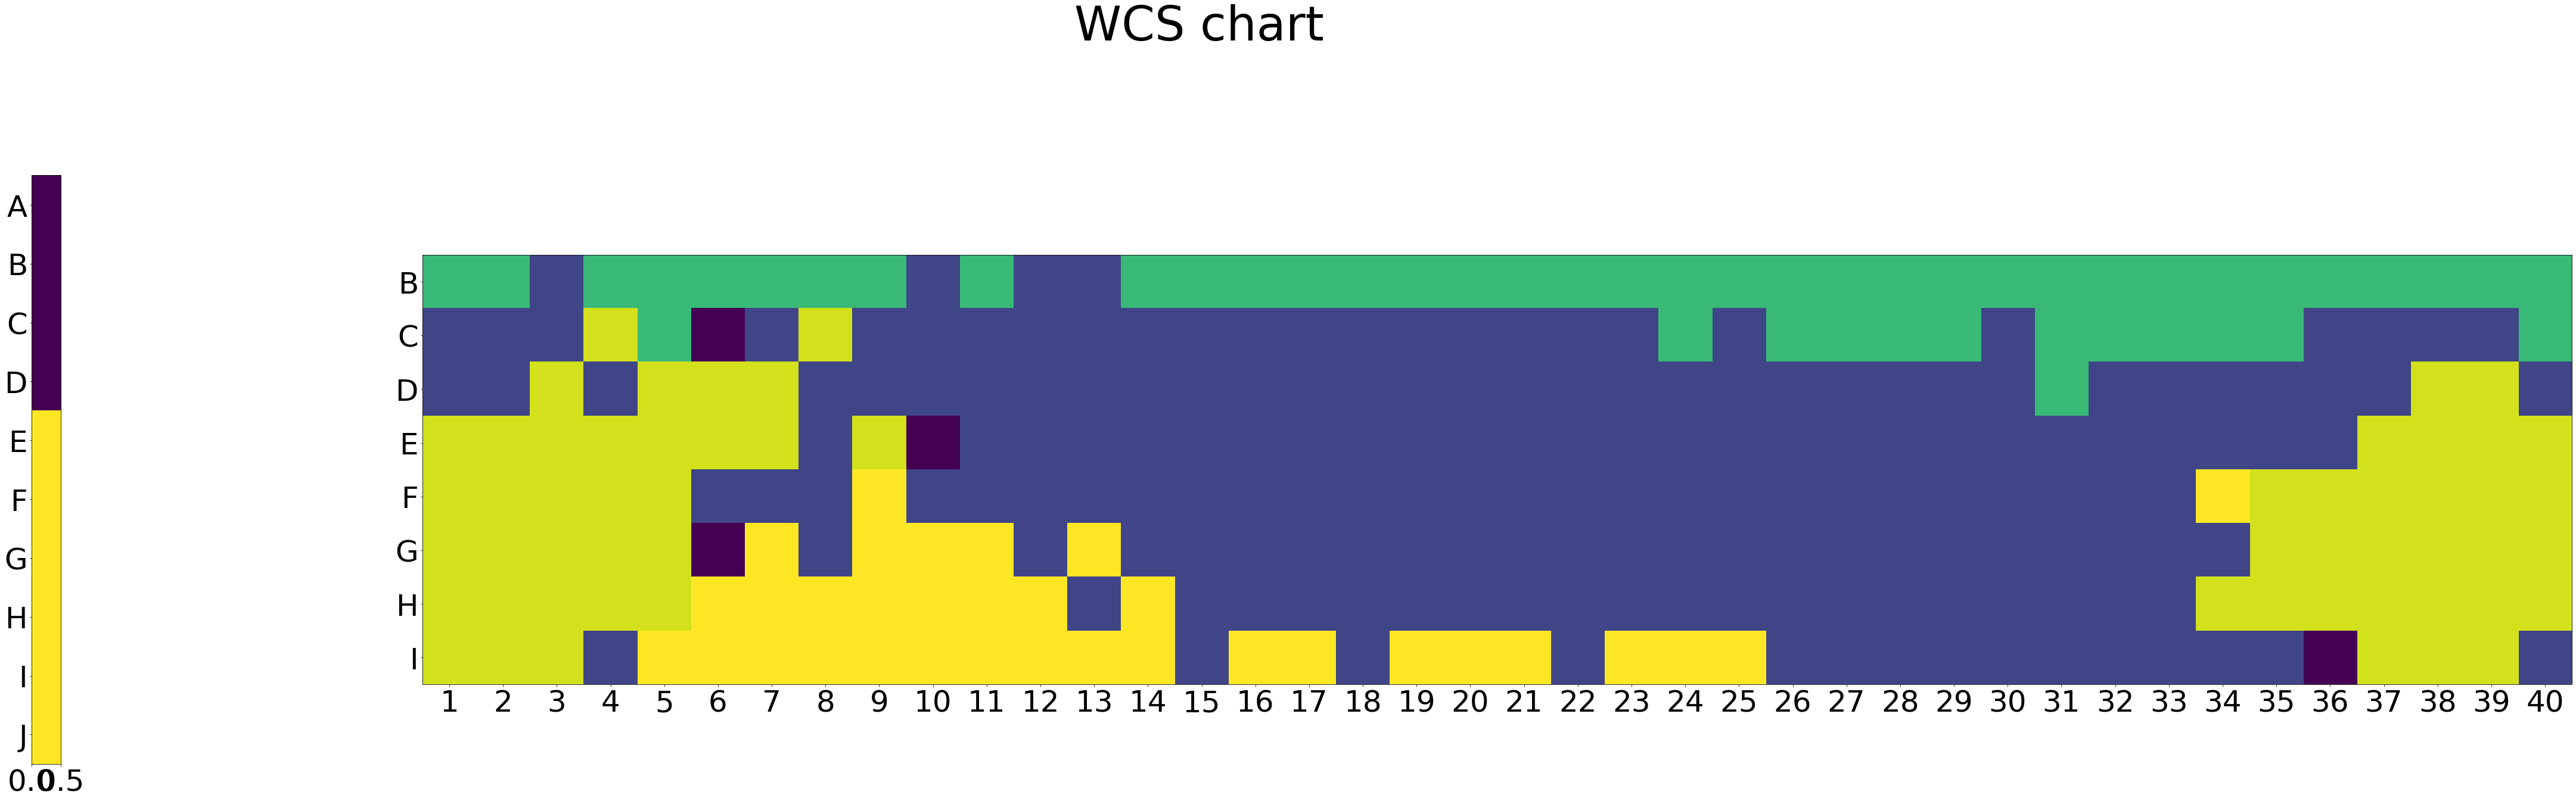

In [23]:
plotValues(encoded_terms)

**Note**: `plotValues()` is a generic function for visualizing various kinds of information on the chart, suited to needs.

Now you are in a position to start exploring this data set - enjoy!

Here we aggregate the data to develop the labels and set up our feature matrix.

In [186]:
ground_truth = {}
ground_truth_data = {}

#doing lanugage 1. This would eventually need to be changed into a for-loop to cycle through every language
language = namingData[1]

for k in language[1].keys():
  # Aggregate all given color terms for each chip   
  ground_truth_data[k] = tuple(d[1][k] for d in language.items())
    
for k in ground_truth_data:
    # choose the color term that appears most frequently as our ground truth value for each chip.
    ground_truth[k] = stats.mode(ground_truth_data[k])

# Our labels for each color chip 

labels = np.array([chip[1].mode[0] for chip in ground_truth.items()])    
# print (labels)

# All unique color terms from the ground truth. These determine our "categories"
color_terms = list(set(labels))
print (color_terms)

# Construct feature matrix
F = [indexCoord[k] for k in range(1,331)]

# print (np.array(F))

# Lightness variable is a letter, lets convert this into an integer.
F = np.transpose(F)
# print (F[0])
light_num = [int(ord(letter)-64) for letter in F[0]]
F = np.transpose([light_num, F[1]])

terms_inds = {}

# Convert coordinates into tuple(int,int) 
F = [tuple([int(coord[0]), int(coord[1])]) for coord in F]

# print (F)

for ind, term in enumerate(labels):
    if term not in terms_inds:
        terms_inds[term] = [F[ind]]
    else:
        terms_inds[term].append(F[ind])

print (terms_inds)

        


for term in color_terms:
    print (term)
    print (np.array([spatial.distance.euclidean(coord, (5,29)) for coord in terms_inds[term] if coord != (5,29)]))
        

        

['F', 'G', 'LF', 'LB', 'S', 'WK', 'LE']
{'G': [(5, 29), (5, 27), (8, 30), (6, 28), (5, 30), (5, 25), (5, 24), (5, 32), (7, 29), (4, 22), (7, 26), (8, 32), (4, 27), (7, 31), (5, 20), (5, 23), (4, 28), (8, 28), (5, 21), (5, 28), (7, 20), (6, 29), (6, 27), (8, 29), (7, 34), (6, 26), (4, 26), (7, 32), (5, 26), (6, 31), (7, 33), (5, 31), (7, 30), (9, 33), (4, 30), (8, 31), (6, 30), (8, 33), (6, 25), (5, 19), (7, 27), (9, 31), (6, 22), (4, 29)], 'F': [(3, 23), (3, 20), (5, 15), (7, 6), (3, 11), (3, 35), (2, 10), (2, 5), (4, 18), (3, 24), (4, 15), (5, 10), (2, 40), (4, 25), (3, 4), (3, 34), (3, 18), (8, 34), (3, 36), (5, 14), (2, 9), (4, 13), (4, 34), (3, 22), (4, 31), (2, 12), (2, 21), (3, 14), (3, 12), (4, 14), (4, 20), (3, 16), (4, 2), (4, 35), (3, 39), (4, 33), (3, 25), (2, 13), (7, 9), (4, 24), (3, 29), (6, 33), (4, 12), (3, 21), (5, 34), (4, 32), (3, 13), (4, 36), (3, 1), (5, 12), (3, 19), (5, 13), (2, 11), (3, 17), (4, 21), (2, 14), (5, 0), (3, 28), (5, 35), (6, 14), (5, 16), (3, 37), 

In [188]:

### Exemplar Model
loo = LeaveOneOut()
loo.get_n_splits(F)

for train_index, test_index in loo.split(F):
    
#   1) Get training and testing data points

    F_train, F_test = np.asarray(F)[train_index], np.asarray(F)[test_index]
    y_train, y_test = labels[train_index], labels[test_index]
    
    print (F_test[0], y_test)
    print (F_test[0]  == (5,29))
    
    
    
    for term in color_terms:
        print (term, ":")
        print (np.array([spatial.distance.euclidean(coord, F_test[0]) for coord in terms_inds[term] if np.all(coord != F_test[0])]))
    
    break 
    dist_dict = {} 
    


[ 5 29] ['G']
[ True  True]
F :
[ 6.32455532  9.21954446 23.08679276 18.11077028  6.32455532 19.23538406
 24.18677324 11.04536102  5.38516481 14.03566885 11.40175425  4.12310563
 25.07987241  5.38516481 11.18033989  5.83095189  7.28010989 20.22374842
 16.03121954  5.09901951  7.28010989  2.23606798 17.2626765   8.54400375
 15.13274595 17.11724277 15.03329638  9.05538514 13.15294644 27.01851217
  6.08276253 10.19803903  4.12310563  4.47213595 16.2788206  20.09975124
  5.09901951  4.12310563 17.02938637  8.24621125  3.16227766 16.1245155
  7.07106781 28.0713377  10.19803903 18.24828759 12.16552506  8.06225775
 15.29705854  2.23606798 15.03329638  8.24621125 10.44030651 29.01723626
  2.23606798 14.14213562 13.03840481]
G :
[3.16227766 1.41421356 7.07106781 3.60555128 4.24264069 2.23606798
 2.82842712 1.41421356 3.16227766 9.21954446 2.23606798 5.38516481
 3.16227766 3.16227766 3.60555128 2.23606798 4.47213595 2.23606798
 5.65685425 1.41421356 3.60555128 1.41421356 5.         4.12310563
 2